# Cleaning and Feature Engineering of the Emory RCC Dataset

## Steps to Take
1. Load dataset into pandas dataframe
1. Summarize info about dataset 
3. Parse dates 
4. Decouple compounded features
5. Transform data
6. Drop single value columns
7. Clean dataframe dtypes
8. Handle outliers
9. Imputation
10. Feature selection
11. Sample dropping
12. Scale and Normalize
13. Clean col names
14. Save cleaned CSV

## Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
%matplotlib inline

2024-03-25 14:52:59.045230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 14:53:00.102099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Load dataset

In [2]:
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('../Data Sources/DO NOT MODIFY/US_RCC_Database.csv', skipinitialspace=True)
df = df.infer_objects()
# Drop all rows and columns that are completely empty
empty_cols = [col for col in df.columns if df[col].isnull().all()]
empty_rows = [row for row in df.index if df.iloc[row].isnull().all()]
print(empty_cols)
print(empty_rows)
df.drop(labels=empty_cols, axis=1, inplace=True)
df.drop(index=empty_rows, axis=0, inplace=True)
data_shape = df.shape
print(data_shape)

['Patient ID', 'Patient MRN', 'Last Name', 'First Name', 'Patient SSN', 'Date of Birth', 'Fistula ']
[]
(1881, 408)


Having run a simple df.shape, this dataset has a total of 415 features and 1881 samples. That is a lot a features for the model to draw from, so we need to make sure they are all relevant to the task.

There are a few columns with duplicate names, we need to go through and adjust these to be more descriptive.

In [3]:
# Handle cols with names that are identical, but end in a space
df.rename(columns={'Sphincter Involvement ': 'Sphincter Involvement_Histopathology',
                   'Intervention Required ': 'Intervention Required_Neoadjvant Complication'}, inplace=True)
# NOTE: First result is 'Primary v. Recurrence', not relevant
dup_cols = df.columns[df.columns.str.contains("\.")].to_list()[1:]
new_names = ['Date of Initiation_NeoadjChemoRad',
            'Date of Completion_NeoadjChemoRad',
            'Number of Mesorectal Nodes by MRI_Post',
            'Number of Mesorectal Nodes by ERUS_Post',
            'Number of Retroperitoneal Nodes by CT_Post',
            'Number of Retroperitoneal Nodes by MRI_Post',
            'Number of Retroperitoneal Nodes by PET-CT_Post',
            'Number of Pelvic Nodes on CT_Post',
            'Number of Pelvic Nodes on MRI_Post',
            'Number of Pelvic Nodes on PET-CT_Post',
            'Involvement of Pelvic Sidewall_Post',
            'Distal Circumferential or Radial Margin (mm)_Post',
            'Sphincter Involvement_Post',
            'Invasion into Reproductive Organs_Post',
            'Invasion into Bladder_Post',
            'Invasion into Sacrum_Post',
            'Invasion of Sacral Nerve Roots_Post',
            'Involvement of Pelvic Sidewall_Op',
            'Omental Flap to Pelvis_Op_APR',
            'T-Stage_Recurrence',
            'N-Stage_Recurrence',
            'Type of Operation of Rectal Tumor_Recurrence',
            'Distal Margin Distance (cm)_Recurrence',
            'Radial Margin Distance (mm)_Recurrence',
            'Date of Diagnosis_PostOp_Leak',
            'Acute Renal Failure_PostOp',
            'Date of Discharge_Readmission',
            'Date of Initiation_AdjChemo',
            'Date of Completion_AdjChemo',
            'Date of Initiation_AdjChemoRad',
            'Date of Completion_AdjChemoRad',
            'Radiation Technique_AdjChemoRad',
            'Date of Initiation_AdjRad',
            'Date of Completion_AdjRad',
            'Sacrum_Recurrence_Locoregional',
            'Bladder_Recurrence_Locoregional',
            'Seminal Vesicles_Recurrence_Locoregional',
            'Prostate_Recurrence_Locoregional',
            'Vagina_Recurrence_Locoregional',
            'Ureter_Recurrence_Locoregional',
            'Grey (Gy)_Recurrence_Rad',
            'Ablation_Recurrence']

df.rename(columns=dict(zip(dup_cols, new_names)), inplace=True)
# Remove whitespace from names
df.rename(columns=lambda x: x.strip(), inplace=True)
# Strip whitespace from all string values and make lowercase
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()
    df[col] = df[col].str.lower()
assert df.shape == data_shape

## 2. Summarize information about dataset
First, to aid in the cleaning process, we'll extract the number of missing and unique (if discrete) values for each feature and save to a file for future reference

In [4]:
def summarize_df(df: pd.DataFrame):
    plot = sns.violinplot(y=df.isnull().sum(), orient="v", width=0.5)
    plot.set_title("Missing Values per Column")
    plt.show()
    plot = sns.violinplot(y=[len(df[col].unique()) for col in df.select_dtypes(include=['object']).columns if "Date" not in col and col != "Database ID"], orient="v", width=0.5)
    plot.set_title("Unique Values per Categorical Feature")
    plt.show()
    plot = df.dtypes.value_counts().sort_values().plot(kind = 'barh')
    plot.set_title("Types of Features in DataFrame")
    plt.show()

    data_info = pd.DataFrame({"Name": df.columns.to_list(),
                          "dtype": df.dtypes.to_list(),
                          "Num Non-Null": df.count(axis=0).to_list(),
                          "Num Unique": [len(df[col].unique()) for col in df.columns]})
    data_info.to_csv("../Data Documentation/cleaned_data_info.csv", index=False)

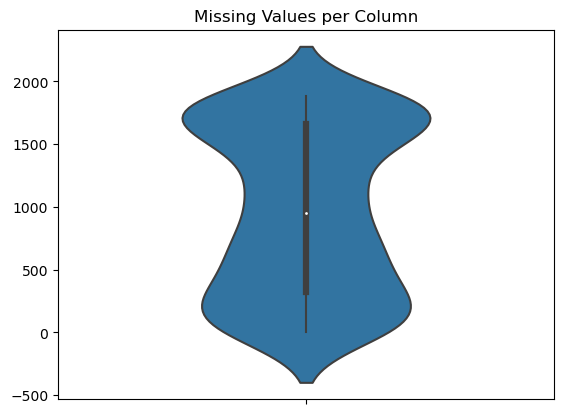

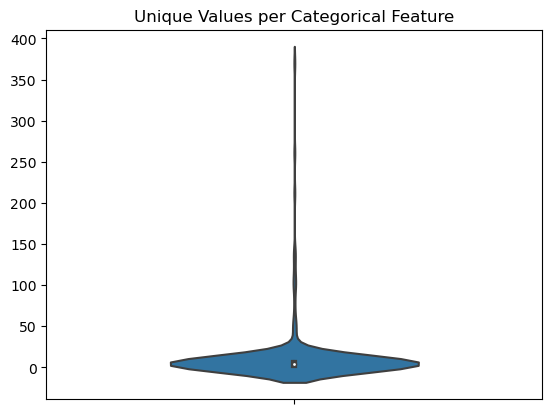

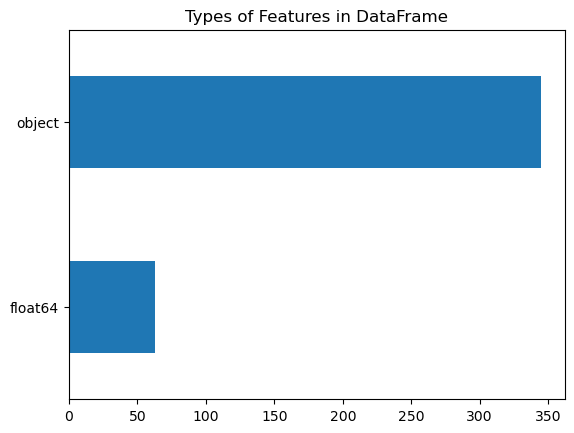

In [5]:
summarize_df(df)

In [6]:
data_info = pd.DataFrame({"Name": df.columns.to_list(),
                          "dtype": df.dtypes.to_list(),
                          "Num Non-Null": df.count(axis=0).to_list(),
                          "Num Unique": [len(df[col].unique()) for col in df.columns]})
data_info.to_csv("../Data Documentation/data_info.csv", index=False)

## 3. Clean dataset

###  Drop unimportant columns
These are columns that either provide unimportant information or have less than 10 non-null samples

In [7]:
drop_cols = ['Complication after Stenting', 'Radiotherapy Complications', 'Intervention for Peritoneal Perforation', 'Radiation Technique_AdjChemoRad', 'Reason for Rectal Stent', 'Date of Completion_AdjRad', 'Grey (Gy)', 'Date of Initiation_AdjRad', 'Ovary']
df = df.drop(columns=drop_cols)

### Binning Data

#### Binning treatments and complications
Each column to be binned has its own dict with the keys being the bins to place the values and the items being an array of unique values that belong in that bin. Chemotherapies will be one hot encoded and given additional features: how many times the therapy was changed, if the cocktail had to be reduced, and what the second therapy was (if applicable). Only the second therapy will be noted because only a handful of samples had more than two therapies. Complications will be one-hot encoded as well, but weighted based on the grade of the complication and the number of other complications of the same nature. All other features will have their unique values concatenated into their respective bin so the model can draw inferences between the magnitude of bins.

In [8]:
def get_unique_tokens(col_name: str, split_indicators: list, df: pd.DataFrame):
    values = df[col_name]
    null_values = values.isnull()
    enumerator = 0
    unique_tokens = []
    for value in values:
        if null_values.get(enumerator) == False:
            for indicator in split_indicators:
                value = value.replace(indicator, ',')
            tokens = value.split(',')
            trigger = False
            for token in tokens:
                token = token.strip().lower()
                for u in unique_tokens:
                    if token == u.lower():
                        trigger = True
                if (not trigger):
                    unique_tokens.append(token)
                trigger = False
        enumerator += 1
    return unique_tokens

In [9]:
def bin(col_name: str, bin_dict: dict, df: pd.DataFrame, one_hot = False, grade_severity = True):
    """Bins feature according to provided dict, retaining the magnitude and severity of occurrences, 
    splitting into separate cols for each key. The contents of each new col is the frequency of the 
    key values in the original data. If a grade is present, the item value increases by the grade number.
    If the one_hot flag is true, values are clipped to 1 and cast to bool."""
    # TODO: Handle data that does not fall under a binning key?
    col_data = df[col_name]
    null_entries = col_data.isnull()
    col_index = df.columns.get_loc(col_name)
    key_num = 0
    for key in bin_dict:
        new_values = []
        items = bin_dict[key]
        iterator = 0
        for data in col_data:
            new_values.append(0)
            if null_entries.get(iterator) == False:
                for item in items:
                    item_index = data.lower().find(item)
                    if item_index != -1:
                        severity = 1
                        # Handle scaling by grade, if present
                        if 'grade' in data.lower() and grade_severity:
                            # Check 'grade' is between the commas bounding the found item
                            grade_index = -1
                            end_comma = data.lower().find(',', item_index)
                            lead_comma = data.lower().rfind(',', 0, end_comma)
                            if end_comma != -1 and lead_comma != -1:
                                grade_index = data.lower().find('grade', lead_comma, end_comma)
                            elif end_comma == -1 and lead_comma != -1:
                                grade_index = data.lower().find('grade', lead_comma)
                            elif end_comma != -1 and lead_comma == -1:
                                grade_index = data.lower().find('grade', 0, end_comma)
                            else: 
                                grade_index = data.lower().find('grade')
                            if grade_index != -1:
                                grade_val_ind = grade_index + 6
                                grade_val = 0
                                # Handle roman numeral (singe edge case w/ 'iii')
                                if data[grade_val_ind] == 'i':
                                    while data[grade_val_ind] == 'i':
                                        grade_val += 1
                                        grade_val_ind += 1
                                else: grade_val = int(data[grade_val_ind])
                                severity = grade_val
                        new_values[iterator] += severity

            # if original value NA, make new val NA as well
            else:
                new_values[iterator] = pd.NA
            iterator += 1
        new_col_name = col_name + '_' + key
        df.insert(col_index, new_col_name, new_values, allow_duplicates = False)
        # Make copy to avert performance warning due to fragmentation
        df = df.copy(deep=True)
        if one_hot:
            df[new_col_name] = df[new_col_name].clip(upper=1)
            df[new_col_name] = df[new_col_name].astype('boolean')
        else: 
            df[new_col_name] = pd.to_numeric(df[new_col_name])
        key_num += 1
    df = df.drop(columns = col_name)
    # Make copy to avert performance warning due to fragmentation
    df = df.copy(deep=True)
    return df

##### Therapy Complications

In [10]:
# NOTE: Some conditions and symptoms will be counted twice, there are a few reasons for this:
# * They belong to two classes at once Ex) 'perianal skin'
# * They are specific in nature, but also cause general pain Ex) 'thrombophlebitis'
# * They are confounded, which increases their severity Ex) 'rectal pain and bleeding'
complication_dict = {
    'Cardiovascular': ['nstemi', 'coronary vasospasm', 'vascular spasm of the fingers', 'thrombophlebitis', 'dvt', 'atrial fibrillation'],
    'Blood/Bone Marrow': ['thrombocytopenia', 'low platelets', 'induced thromboctopenia', 'anemia', 'low wbc', 'neutropenia', 'sepsis', 'cytopenia', 'necrosis', 'bacteremia'],
    'Constitutioinal Symptoms': ['nose and lip bleeding', 'suicidal ideations', 'anorexia', 'sirs', 'dehydration', 'failure to thrive', 'fatigue', 'cold intolerance', 'night sweats', 'cold sensitivity', 'hair loss', 'dizziness', 'nausea', 'vomitting', 'tongue and throat sensitivity', 'alopecia', 'allergic reaction', 'abdominal cramping'],
    'Dermatology': ['periananl skin', 'rash', 'hand foot syndrome', 'gout flare', 'hand and foot', 'palmar-plantarerythrodysesthesia', 'dermatitis', 'cellulitis', 'pruritis', 'skin toxicity', 'skin erythema', 'desquamation', 'skin reaction', 'skin irrritation', 'perineal and vaginal skin irritation', 'skin changes', 'pruritus', 'hand-foot syndrome', 'skin issues', 'abscess'],
    'Reproductive': ['genital herpes', 'erectile dysfunction', 'menorrhagia', 'vagina'], 
    'Pulmonary': ['pneumothorax', 'pe', 'pulmonary hypertension', 'tracheal bronchitis', 'pneumonia'], 
    'Renal': ['ureter obstruction', 'acute kidney injury', 'aki', 'urinary', 'uti', 'incontinence', 'dysuria'],
    'Pain': ['low backache', 'pain', 'perirectal burning', 'thrombophlebitis', 'gout', 'cramping', 'dysuria', 'sores', 'ulcers', 'hernia', 'abscess'],
    'Neurology': ['numb', 'neuropathy', 'taste alteration', 'chemo brain'], 
    'Gastrointestinal': ['diarrhea', 'constipation', 'esophageal spasm', 'fecal obstruction', 'gi', 'colitis', 'bowel obstruction', 'sbo', 'dysphagia', 'mucositis', 'crohn', 'pyroderma gangrenosum', 'hernia', 'ileitis', 'enteritis', 'pneumatosis', 'diverticulitis', 'mucousitis', 'stomatitis'],
    'Rectum': ['proctitis', 'rectal', 'anal', 'periananl', 'perineal', 'fistula', 'inguinal', 'rectal pain and bleeding', 'hemorrhoids', 'prostatitis']
}

df = bin('Complication During Neoadjuvant Treatment', complication_dict, df)

/tmp/ipykernel_364695/1876493906.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(col_index, new_col_name, new_values, allow_duplicates = False)


##### Intraoperative Complications

In [11]:
operative_dict = {
    'GI Mesenteric Vessel Injury': ['mesenteric injury', 'colonic ischemia requiring excision of colon to hepatic flexure', 'ischemia noted without obvious vascular injury/disruption. distal transverse and descending colon were resected along with appendectomy', 'colorectal anastomosis', 'ischemia to colon requiring deloters procedure'],
    'GI Rectal Injury': ['bladder injury - Urinary tract hole in rectal stump after firing stapler', 'tear in rectum distal to anastomosis', 'entered the vagina and the rectal lumen accidentally', 'rectal injury', 'proctotomy'],
    'GI Anastomotic Leak': ['anastamotic defect', 'anastomotic leak requiring dli', 'staples did not hold rectal stump closed', 'anatosmotic leak repaired', 'positive leak test'],
    'Vaginal Injury': ['vaginal injury', 'hole created in posterior vaginal wall', 'entered the vagina and the rectal lumen accidentally', 'colpotomy'],
    'GI Small Bowel Injury': ['small bowel cautery injury', 'bowel injury', 'small bowel enterotomy'],
    'Prostate Injury': ['tear in rectum distal to anastomosis'],
    'Bleeding-Operative': ['bleeding', 'acidosis'],
    'Urinary Tract Injury': ['bladder injury', 'ureteral injury', 'coagulopathy', 'urethral injury'],
    'Spleen Injury': ['splenic capsule tear']
}
df = bin('Type of Intraoperative Complication', operative_dict, df)

##### Organs Invaded

In [12]:
organ_dict = {
    'Reproductive-Invaded': ['vagina', 'vas deferens', 'cervix', 'prostate', 'seminal vesticles', 'uterus', 'fallopian tube', 'ovaries', 'scrotum', 'ovary'],
    'Colon': ['colon'],
    'Anus': ['anus', 'peri-anal skin with metastatic lesion'],
    'Urinary Tract': ['urinary', 'periureteral soft tissue', 'bladdder', 'ureter', 'bladder'],
    'Nodes': ['nodes'],
    'Sacrum-Invaded': ['pre-sacral tissue', 'sacrum'],
    'Liver-Invaded': ['liver'],
    'Pelvic Bone': ['pelvic wall', 'obturator side wall', 'coccyx', 'pelvis', 'pelvic side wall', 'perisacral soft tissue'],
    'Pelvic Floor': ['pelvic floor muscle'],
    'Omentum': ['omentum'],
    'Spleen': ['spleen'],
    'Peritoneum': ['peritoneum'],
    'Soft Tissue': ['ab wall', 'buttocks'],
    'Small Bowel-Invaded': ['small bowel', 'ileum'],
    'Stomach': ['stomach'],
    'Mesentery': ['mesentary', 'mesentery'],
    'Vessels': ['iliac vessels']
}

df = bin('Organs Invaded', organ_dict, df)

##### Diagnosis at Readmission

The column 'Diagnosis at Readmission' has 146 unique values for only 403 non-null samples. 

In [13]:
readmission_dict = {
    'Cardiovascular': ['nstemi', 'dvt', 'fibrillation', 'heart failure', 'arrhythmia', 'cva', 'tachycardia', 'myocardial infarction', 'arrest', 'cardiomyopathy', 'svt'],
    'Blood': ['bleed', 'hematoma', 'pe', 'pulmonary embolus', 'hematuria', 'portal vein thrombosis', 'dvt', 'anemia', 'sepsis', 'bacteremia', 'dka', 'supratherapeutic inr'],
    'Constitutional Symptoms': ['dehydration', 'failure to thrive', 'fatigue', 'dizziness', 'nausea',  'syncope', 'confusion', 'anxiety', 'deconditioning', 'weakness'],
    'Pelvic/Vaginal': ['vagina', 'pelvic', 'perineal', 'presacral', 'retroperitneal'], 
    'Pulmonary': ['pe', 'pneumonia', 'respiratory', 'pulmonary embolus', 'lung', 'pleural effusion', 'pneumomediastinum', 'dyspnea'], 
    'Renal': ['acute kidney injury', 'aki', 'urinary', 'uti', 'incontinence', 'dysuria', 'hematuria', 'pyelonephritis', 'urosepsis', 'renal', 'uropathy', 'hydronephrosis', 'biliary obstruction'],
    'Pain': ['pain', 'dysuria', 'abscess', 'hernia'],
    'Gastrointestinal': ['diarrhea', 'constipation', 'gi', 'bowel obstruction', 'enteritis', 'c. diff', 'liver', 'melena', 'peritoneal', 'ileus', 'gastritis', 'obstipation', 'abdominal', 'hepatic', 'obstruction from food bolus', 'anastomosis', 'anastomotic', 'anastamoses', 'internal hernia', 'colo', 'peritonitis'],
    'Rectum': ['rectal', 'anal', 'recto'],
	'Operative': ['hematoma', 'ostomy', 'parastomal', 'periostomal', 'ostomy appliance dysfunction', 'lapro right hemicolectomy', 'complication', 'leak', 'anastamoses', 'stricture', 'dehiscence', 'surgical', 'ssi', 'malfunctioning foley', 'anastomosis', 'nonhealing perineal wound', 'fistula', 'bleeding from perineal wound'],
	'Cancer-related': ['carcinoma', 'metastasis', 'metastisis', 'mets', 'mass', 'cancer', 'recurrence', 'nodules', 'chemotherapy'],
	'Illness/Infection': ['infection', 'pneumonia', 'uti', 'sepsis', 'bacteremia', 'fever', 'pyelonephritis', 'ssi', 'flu'],
	'Misc': ['neurosurgery consult', 'no surgical intervention', 'fall', 'unknown', 'skin excoriation', 'dysphasia', 'nerve'],
}

df = bin('Diagnosis at Readmission', readmission_dict, df, grade_severity = False)

##### Chemo Regimens
Make a seperate feature that indicates if a patient had to switch regimens

In [14]:
def bin_chemo(col_name: str, bin_dict: dict, df: pd.DataFrame):
    """Bins chemo regimen column according to provided dictionary. Adds features for 
    the # of changes to the regimen, if the regimen needed to be reduced, and any secondary regiments"""
    col_data = df[col_name]
    chemo_reduced = []
    chemo_changed = []
    chemo_initial = []
    chemo_secondary = []
    for sample in col_data:
        if not pd.isnull(sample):
            sample = sample.lower()
            # Count times reg. reduced by the frequency of 'reduce', '%', or 'discontinue'
            # NOTE: one known edge case where 'reduce' and '%' are redundant (DID: UM061)
            chemo_reduced.append(sum(sample.count(indicator) for indicator in ["reduce", "%", "discontinue"]))
            # Count the number of changes by the frequency of ',', '>', or ';'
            change_indicators = [",", ">", ";"]
            chemo_changed.append(sum(sample.count(indicator) for indicator in change_indicators))
            # Split string on first change
            if chemo_changed[-1] > 0:
                for indicator in change_indicators:
                    change_ind = sample.find(indicator)
                    if change_ind > 0:
                        chemo_initial.append(sample[:change_ind])
                        secondary = sample[change_ind:]
                        # If a therapy was added to the initial (only one edge case)
                        if secondary.find("add", 10) != -1: secondary = sample
                        chemo_secondary.append(secondary)
                        break
            else: 
                chemo_initial.append(sample)
                chemo_secondary.append('None')
        else:
            chemo_reduced.append(pd.NA)
            chemo_changed.append(pd.NA)
            chemo_initial.append(pd.NA)
            chemo_secondary.append(pd.NA)

    df.insert(df.columns.get_loc(col_name), col_name + "_Secondary", chemo_secondary, allow_duplicates = False)
    df.insert(df.columns.get_loc(col_name), col_name + "_Initial", chemo_initial, allow_duplicates = False)
    df.insert(df.columns.get_loc(col_name), col_name + "_Changes", chemo_changed, allow_duplicates = False)
    df[col_name + "_Changes"] = pd.to_numeric(df[col_name + "_Changes"])
    df.insert(df.columns.get_loc(col_name), col_name + "_Reductions", chemo_reduced, allow_duplicates = False)
    df[col_name + "_Reductions"] = pd.to_numeric(df[col_name + "_Reductions"])
    df = df.drop(columns = col_name)

    df = bin(col_name + "_Initial", bin_dict, df, True)
    df = bin(col_name + "_Secondary", bin_dict, df, True)    

    return df

In [15]:
chemo_dict = {
    'Folfox': ['xelox', 'folfox', 'oxaliplatin', 'flox', 'capox', 'folfirinox', 'capeox', 'xeliri', 'foflox', 'xeleri'],
    '5FU': ['xeloda', 'capecitabine', '5-fu', 'leucovorin', '5fu', 'leocovorin', 'leukovorin', 'cabecitabine'],
    'Biologic': ['avastin', 'bbi', 'panitumumab', 'pembro', 'nivolumab', 'erbutux', 'cetuximab', 'erbitux', 'bev', 'cituximab', 'vectibix', 'xl888 trial', 'panitumaumab', 'lonsurf', 'ipilimumab', 'avastn', 'cetuximab', 'avastatin', 'avasrin'],
    'Folfiri': ['irinotecan', 'folfiri', 'capiri', 'bi5013', 'folriri'],
    'Interleukin': ['nktr-214 (pegylated il-2)'],
    'Alt Chemo': ['etoposide', 'camtosar', 'cisplatin', 'carboplatin', 'carboxyplatin', 'mmc', 'other']
}

regimen_cols = ['Neoadjuvant Chemo Regimen', 'Adjuvant Chemo Regimen', 'Chemotherapy Regimen']
for col in regimen_cols:
    df = bin_chemo(col, chemo_dict, df)

# Drop 'Chemotherapy Regimen_Reductions', non-na values are all 0
df = df.drop(columns='Chemotherapy Regimen_Reductions')

#### Other binning

One-hot encode possible values for 'Location of Metastatic Disease', 'Prior Abdominal Operation', 'Radiation Dose', 'CURRENT Tumor Category', 'Region of Recurrence'. This is a lot simpler, common tokens and separated by ' + '

In [16]:
metastatic_dict = {
    'Peritoneum': ['peritoneum'],
    'Lung': ['lung'],
    'Liver': ['liver'],
    'Other': ['other'],
}

df = bin('Location of Metastatic Disease', metastatic_dict, df, True)

In [17]:
prior_ab_op_dict = {
    'Open': ['open'],
    'Laparoscopic': ['laparoscopic']
}

df = bin('Prior Abdominal Operations', prior_ab_op_dict, df, True)

In [18]:
rad_dose_dict = {
    'Standard': ['standard'],
    'Boost': ['boost']
}

df = bin('Radiation Dose', rad_dose_dict, df, True)

In [19]:
tumor_cat_dict = {
    'Primary Rectal Tumor': ['primary rectal'],
    'Recurrent Rectal Tumor': ['recurrent rectal'],
    'Synchronous Liver Metastases': ['liver metastases'],
}

df = bin('CURRENT Tumor Category', tumor_cat_dict, df, True)

In [20]:
region_dict = {
    'Local': ['local'],
    'Regional': ['regional'],
    'Distant': ['distant'],
}

df = bin('Region of Recurrence', region_dict, df, True)

Most values in 'Distal Circumferential or Radial Margin (mm)' and 'Distal Circumferential or Radial Margin (mm)_Post' are either '>0' or '0', so we'll bin along these lines

In [21]:
# Convert all '> 0' values to 1's for binning
df['Distal Circumferential or Radial Margin (mm)'].replace(to_replace="> 0", value=1, inplace=True)
df['Distal Circumferential or Radial Margin (mm)'] = pd.to_numeric(df['Distal Circumferential or Radial Margin (mm)'])
df['Distal Circumferential or Radial Margin (mm)_Post'].replace(to_replace="> 0", value=1, inplace=True)
df['Distal Circumferential or Radial Margin (mm)_Post'] = pd.to_numeric(df['Distal Circumferential or Radial Margin (mm)_Post'])

# Bin using pd.cut
df['Distal Circumferential or Radial Margin (mm)'] = pd.cut(df['Distal Circumferential or Radial Margin (mm)'], [-1000000000, 0, 1000000000], labels = ['0', '>0'])
df['Distal Circumferential or Radial Margin (mm)_Post'] = pd.cut(df['Distal Circumferential or Radial Margin (mm)_Post'], [-1000000000, 0, 1000000000], labels = ['0', '>0'])

TODO: Gather miscellaneous values

Consider:
- Change all non-na values to 'Yes' and na values to 'No' for 'Previous Diagnosis of Cancer'
- Any possible binning for 'Method of Metastatic Tumor Biopsy', 'Method of Metastatic Tumor Biopsy'

In [22]:
# NOTE: Assume text data all made lowercase, so ignore case in following steps
# Change any 'Data Unavailable' values to be null
df = df.replace(to_replace=r'data unavailable', value=np.nan, regex=True)

# Change any 'Not applicable' or 'Not applicablet applicable' values to be null for 'Indication for Palliative Resection', 'Operative Approach', 'Reason for Conversion to Open', 'Method of Metastatic Tumor Biopsy', 'Mobilization of Splenic Flexure', 'Ulcerative Colitis', 'Crohn's Disease', 'Method of Anastomosis', 'Additional Pelvic Nodes Resected', 'Sacrum', 'Final Proximal Margin Status', 'Final Distal Margin Status', 'Final Radial Margin Status', 'Tumor Budding', 'Necrosis', 'Mucinous', 'KRAS Status', 'BRAF Status', 'APC Status', 'P53 Status', 'MLH1 Status', 'MSH2 Status', 'MSH6 Status', 'PMS2 Status', 'Method of Total Mesorectal Excision', 'Repair of Perineal Hernia', 'Indication for Reoperation', 'Surveillance by EUS'
# na_replace = ['Indication for Palliative Resection', 'Operative Approach', 'Reason for Conversion to Open', 'Method of Metastatic Tumor Biopsy', 'Mobilization of Splenic Flexure', 'Ulcerative Colitis', "Crohn's Disease", 'Method of Anastomosis', 'Additional Pelvic Nodes Resected', 'Sacrum', 'Final Proximal Margin Status', 'Final Distal Margin Status', 'Final Radial Margin Status', 'Tumor Budding', 'Necrosis', 'Mucinous', 'KRAS Status', 'BRAF Status', 'APC Status', 'P53 Status', 'MLH1 Status', 'MSH2 Status', 'MSH6 Status', 'PMS2 Status', 'Method of Total Mesorectal Excision', 'Repair of Perineal Hernia', 'Indication for Reoperation', 'Surveillance by EUS']
# df[na_replace] = df[na_replace].replace(to_replace=r'not applicable|not applicablet applicable', value=np.nan, regex=True)

# Change any 'No reason stated' values to be null for 'Reason for Conversion to Open'
# df['Reason for Conversion to Open'] = df['Reason for Conversion to Open'].replace('no reason stated', np.nan)

# Group 'Child Class A' and 'Child Class B' together as 'Yes' for 'Chronic Liver Disease'
# df['Chronic Liver Disease'] = df['Chronic Liver Disease'].replace({'child class a': 'yes', 'child class b': 'yes'})

# Group all values containing 'incontinence' together in col 'Pre-Treatment Bladder Dysfunction', 'Bladder Dysfunction'
# bladder_cols = ['Pre-Treatment Bladder Dysfunction', 'Bladder Dysfunction']
# df[bladder_cols] = df[bladder_cols].replace(r'^.*incontinence.*$', 'incontinence', regex=True)

# Make all non-na values 'Yes' for 'Pre-Treatment Sexual Dysfunction', 'Pre-Treatment Fecal Incontinence', 'Bowel Obstruction', 'Malignant Fistula', 'Ulcerative Colitis', 'Crohn's Disease', 'Additional Pelvic Nodes Resected', 'Sacrum', 'Sexual Dysfunction', 'Fecal Incontinence', 'Repair of Perineal Hernia'
# fill_yes_cols = ['Pre-Treatment Sexual Dysfunction', 'Pre-Treatment Fecal Incontinence', 'Bowel Obstruction', 'Malignant Fistula', 'Ulcerative Colitis', "Crohn's Disease", 'Additional Pelvic Nodes Resected', 'Sacrum', 'Sexual Dysfunction', 'Fecal Incontinence', 'Repair of Perineal Hernia']
# df[fill_yes_cols] = df[fill_yes_cols].mask(df[fill_yes_cols].notna(), 'yes')

# Make all non 'No', non-na values 'Yes' for 'Diverting Ostomy Before Surgery', 'Ureteral Obstruction', 'Pelvic Exenteration'
# fill_non_no_cols = ['Diverting Ostomy Before Surgery', 'Ureteral Obstruction', 'Pelvic Exenteration']
# df[fill_non_no_cols] = df[fill_non_no_cols].mask((df[fill_non_no_cols] != 'no') & (df[fill_non_no_cols].notna()),'yes')

# Changed 0 to 'No' and 1 to 'Yes' in 'Portion of Sphincters Resected', 'Defect Closure', 'Peritoneal Perforation', 'Positive Margin Requiring Re-excision', 'Need for Radical Resection', 'Intervention Required', 'Ostomy Reversed after Resolution of Leak', 'Radiation' 
binary_replace = ['Portion of Sphincters Resected', 'Defect Closure', 'Peritoneal Perforation', 'Positive Margin Requiring Re-excision', 'Need for Radical Resection', 'Intervention Required', 'Ostomy Reversed after Resolution of Leak', 'Radiation']
df[binary_replace] = df[binary_replace].replace({1: 'yes', 0: 'no'})

# Change all values containing 'adenocarcinoma' to 'Adenocarcinoma' and all other non-na values to 'Other' for 'Histopathologic Type'
# df['Histopathologic Type'] = df['Histopathologic Type'].replace(r'^.*adenocarcinoma.*$', 'adenocarcinoma', regex=True)
# df['Histopathologic Type'] = df['Histopathologic Type'].mask(~(df['Histopathologic Type'].str.contains('adenocarcinoma').astype('bool')) & (df['Histopathologic Type'].notna()), 'other')

# Change all 'Cannot be assessed' values to null for 'Tumor Differentiation', 'Final Proximal Margin Status',  'Final Distal Margin Status', 'Final Radial Margin Status' 
# cba_cols = ['Tumor Differentiation', 'Final Proximal Margin Status',  'Final Distal Margin Status', 'Final Radial Margin Status']
# df[cba_cols] = df[cba_cols].replace({'cannot be assessed': np.nan})

# Change all 'Not assessed' values to be null for 'Lymphovascular Invasion (LVI)', 'Perineural Invasion (PNI)', 'KRAS Status', 'BRAF Status', 'APC Status', 'P53 Status', 'MLH1 Status', 'MSH2 Status', 'MSH6 Status', 'PMS2 Status'
na_cols = ['Lymphovascular Invasion (LVI)', 'Perineural Invasion (PNI)', 'KRAS Status', 'BRAF Status', 'APC Status', 'P53 Status', 'MLH1 Status', 'MSH2 Status', 'MSH6 Status', 'PMS2 Status']
df[na_cols] = df[na_cols].replace({'not assessed': np.nan})

# Make any values containing 'negative' equal 'Negative for carcinoma' and 'positive' equal 'Positive for carcinoma' for 'Final Proximal Margin Status', 'Final Distal Margin Status', 'Final Radial Margin Status'
# status_cols = ['Final Proximal Margin Status', 'Final Distal Margin Status', 'Final Radial Margin Status']
# df[status_cols] = df[status_cols].replace(r'^.*negative.*$', 'negative for carcinoma', regex=True)
# df[status_cols] = df[status_cols].replace(r'^.*positive.*$', 'positive for carcinoma', regex=True)

# Make all non-na, non 'Dysplasia' values equal 'Other' for 'Additional Pathologic Findings'
# df['Additional Pathologic Findings'] = df['Additional Pathologic Findings'].mask(~(df['Additional Pathologic Findings'].str.contains('dysplasia').astype('bool')) & (df['Additional Pathologic Findings'].notna()), 'other')

# Make any values containing 'rehab' equal 'Rehab' for 'Discharge Destination'
# df['Discharge Destination'] = df['Discharge Destination'].replace(r'^.*rehab.*$', 'rehab', regex=True)

# Make single 'li fraumeni' value equal 'other' for 'Known Genetic Syndrome'
# df['Known Genetic Syndrome'] = df['Known Genetic Syndrome'].replace('li fraumeni', 'other')

### Drop leftover dirty samples
- Dropped samples with the value 'â‰¥10-19 yearsNot applicable years' from Crohn's Disease
- Dropped sample with the value '4' in Weight Loss
- Dropped samples with Database ID 'UP0272' and 'VU025', date of diagnosis was not a fully formatted date and was causing errors
- Dropped all samples with the value '4' in Tumor Differentiation
- Dropped single '1' value from Type of Operation of Rectal Tumor_Recurrence
- Dropped sample with Database ID 'UP0072', Anastonomic Leak diagnosis date was 7/11/01. Probably a typo for 2011, but better to drop just in case
- Dropped 2 samples with the value '3' in Method of Leak Diagnosis
- Dropped samples with values '1', '2', and '3' in Type of Intervention
- Dropped single sample with the value 'UnkNown' in Adjuvant Chemoradiation
- Dropped samples with values of 1433.2 and 1436.1 in Recurrence Free Survival (Months)
- Dropped samples with value '5' in 'Pre-Treatment Bladder Dysfunction'
- Drop sample with value '4' in 'Staging CT Chest'
- Drop 2 samples with value 'Proton therapy' in 'Radiation Technique'
- Drop 1 sample with value '4' in 'Omental Flap to Pelvis'
- Drop 1 sample with value '2' in 'Lesion Distribution' (*Note: Could be interpreted as 'bilobar'?*)

Consider:
- Drop single sample with value 'Li Fraumeni' in 'Known Genetic Syndrome'
- Drop single sample with value 'Complete small bowel obstruction' in 'Bowel Obstruction'

In [23]:
def drop_invalid_samples(invalid: list, col_name: str, df: pd.DataFrame):
    drop_inds = df[df[col_name].str.contains('|'.join(invalid), na=False)].index
    print("Dropping {} samples containing one of {} from column {}".format(len(drop_inds), invalid, col_name))
    return df.drop(drop_inds)

In [24]:
df = drop_invalid_samples(["≥10-19 yearsnot applicable years"], "Crohn's Disease", df)
df = drop_invalid_samples(["4"], "Weight Loss", df)
df = drop_invalid_samples(["up0272", "vu025", "up0072"], "Database ID", df)
df = drop_invalid_samples(["4"], "Tumor Differentiation", df)
df = drop_invalid_samples(["1"], "Type of Operation of Rectal Tumor_Recurrence", df)
df = drop_invalid_samples(["3"], "Method of Leak Diagnosis", df)
df = drop_invalid_samples(["1", "2", "3"], "Type of Intervention", df)
df = drop_invalid_samples(["unknown"], "Adjuvant Chemoradiation", df)
df = drop_invalid_samples(["5"], "Pre-Treatment Bladder Dysfunction", df)
df = drop_invalid_samples(["4"], "Staging CT Chest", df)
df = drop_invalid_samples(["proton therapy"], "Radiation Technique", df)
# NOTE: Last two will not drop any samples, have already been dropped by prev operations
df = drop_invalid_samples(["4"], "Omental Flap to Pelvis", df)
df = drop_invalid_samples(["2"], "Lesion Distribution", df)

# Numeric col, must handle separately
rfs = df['Recurrence Free Survival (months)']
drop_inds = df[(rfs == 1433.2) | (rfs == 1436.1)].index
print("Dropping {} samples from column Recurrence Free Survival (months)".format(len(drop_inds)))
df = df.drop(drop_inds)

Dropping 6 samples containing one of ['≥10-19 yearsnot applicable years'] from column Crohn's Disease
Dropping 1 samples containing one of ['4'] from column Weight Loss
Dropping 3 samples containing one of ['up0272', 'vu025', 'up0072'] from column Database ID
Dropping 12 samples containing one of ['4'] from column Tumor Differentiation
Dropping 1 samples containing one of ['1'] from column Type of Operation of Rectal Tumor_Recurrence
Dropping 2 samples containing one of ['3'] from column Method of Leak Diagnosis
Dropping 12 samples containing one of ['1', '2', '3'] from column Type of Intervention
Dropping 1 samples containing one of ['unknown'] from column Adjuvant Chemoradiation
Dropping 5 samples containing one of ['5'] from column Pre-Treatment Bladder Dysfunction
Dropping 0 samples containing one of ['4'] from column Staging CT Chest
Dropping 1 samples containing one of ['proton therapy'] from column Radiation Technique
Dropping 0 samples containing one of ['4'] from column Omenta

### Fixing dtypes

Standardize the units for duration columns to all be in weeks. Values in months can be converted, but values in 'cycles' cannot and will be dropped
* Adjuvant Chemo Duration: weeks
* Duration of Neoadjuvant Chemo (months): months
* Duration of Neoadjuvant ChemoXRT (in months): months

Excluding:
- 'Return of Bowel Function': units in days
- 'Time to Drain Removal (days)': units in days
- 'Time to Ileostomy Reversal (days)': units in days
- 'LOS (days)': units in days
- 'LOS Readmission': units likely in days

In [25]:
duration_cols = ['Adjuvant Chemo Duration', 'Duration of Neoadjuvant Chemo (months)', 'Duration of Neoadjuvant ChemoXRT (in months)']

for col in duration_cols: 
    df = drop_invalid_samples(['cycles'], col, df)
    for index in range(len(df[col])):
        if pd.isnull(df[col].values[index]): continue
        sample = str(df[col].values[index]).lower()
        # NOTE: With 'cycles' removed, the samples in these cols can only have the suffix 'months'
        if 'months' in col or 'months' in sample:
            sample = int(sample.strip(' months'))
            sample *= 4
            df[col].values[index] = str(sample)
    df[col] = pd.to_numeric(df[col])

Dropping 2 samples containing one of ['cycles'] from column Adjuvant Chemo Duration
Dropping 0 samples containing one of ['cycles'] from column Duration of Neoadjuvant Chemo (months)
Dropping 0 samples containing one of ['cycles'] from column Duration of Neoadjuvant ChemoXRT (in months)


TODO: Several features that should be numeric are being interpreted as strings or objects because of some values that contain ranges. We need to either drop these values, bin them, or impute with the mean of their interval

In [26]:
def impute_ranges(col: pd.Series, range_indicators=['>', '<', '≥', 'greater than'], method='median', violin=True) -> pd.Series:
    """Impute samples that are ranges (containing <, ≥, >, or greater than) with the mean or median in their range.
    Optionally create a violin plot of the numeric values to determine whether mean or median is best."""
    if method != "median" and method != "mean":
        print("ERROR: arg method must be one of 'median' or 'mean'!")
        return col
    if col.dtype != 'object':
        print("Passed col is not of type 'object'")
        return col
    # Collect all samples that are ranges
    range_samples = col.str.contains('|'.join(range_indicators), na=False)
    # Make new series w/ only numeric samples
    numeric_samples = col.loc[(~range_samples) & col.notna()].astype('float').reset_index(drop=True)
    if violin:
        plot = sns.violinplot(numeric_samples)
        plot.set_title(col.name)
        plt.show()
    # Iterate over samples that are ranges and impute
    range_inds = col[range_samples].index.to_list()
    for i in range_inds:
        sample = col[i]
        if '>' in sample:
            bound = float(sample.split('>')[1])
            vals_in_range = numeric_samples[numeric_samples > bound]
        elif 'greater than' in sample:
            bound = float(sample.split('greater than')[1])
            vals_in_range = numeric_samples[numeric_samples > bound]
        elif '≥' in sample:
            bound = float(sample.split('≥')[1])
            vals_in_range = numeric_samples[numeric_samples >= bound]
        elif '<' in sample:
            bound = float(sample.split('<')[1])
            vals_in_range = numeric_samples[numeric_samples < bound]
        else: 
            print("ERROR: No match found at index {}", i)
            continue
        match method:
            case "median":
                col[i] = vals_in_range.median()
            case "mean":
                col[i] = vals_in_range.mean()
    return pd.to_numeric(col)

In [27]:
range_cols = ['CEA (ng/mL)', 'CEA Level (ng/mL) at Recurrence', 'Distal Margin Distance (cm)', 'Radial Margin Distance (mm)', 'Proximal Margin Distance (cm)', 'Post-Treatment Tumor Diameter (cm)', 'Number of Staple Fires to Transect Rectum']

lesions_nodes_cols = df.columns[df.columns.str.contains(r'^#.*Lesions.*$|^Number.*Nodes.*$', regex=True)].to_list()

range_cols.extend(lesions_nodes_cols)

# for col in range_cols:
#     impute_ranges(df[col])


TODO: Some features are objects but can be represented as hierarchial numeric features. We need to parse these. *Note: All 'Data Unavailable' values should be na by this point*
- 'Clinical Response after Neoadjuvant Treatment': {1: 'cNon', 2: 'pCR', 3: 'cCR'}
- 'Wound Class': Cut 'Class' and convert roman numerals to ints
- Cancer stage features (incl 'TNM Grade' and 'Depth of Invasion'): Place in hierarchy according to [ACS guidelines](https://www.cancer.org/cancer/types/colon-rectal-cancer/detection-diagnosis-staging/staged.html)
- 'Tumor Differentiation': According to [tumor grade](https://www.cancer.gov/about-cancer/diagnosis-staging/diagnosis/tumor-grade)
- 'Final Primary Rectal Tumor Resection Status', 'Final LIVER Resection Status': Cut 'R' and cast to int
- 'Pathologic Response': {1: 'No response', 2: 'Partial response', 3: 'Complete response'}
- 'Completeness of TME': {1: 'Incomplete', 2: 'Near Complete', 3: 'Complete'}
- 'Minor vs Major Complication': {1: 'No complication', 2: 'Minor complication', 3: 'Major complication'}
- 'Highest Clavien-Dindo Grade': According to Fig 1 [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1360123/)
- 'Time to Readmission', 'Time to Death': Start with 1 for '≤30 days', end with 4 for '>90 days'
- 'Locoregional Surveillance Frequency', 'Distant Surveillance Frequency': Start w/ 1 for '3-4 months', end at 3 for 'annual'
- Locations of recurrence: {0: 'No', 3: 'Yes - Treated', 2: 'Yes - Not treated'} (*Note: 0-indexed bc null values can be imputed with 0. Not treated is highest value b/c it is 'worse'*)

Consider:
- 'Type of Resection': Only non-na values include 'minor' and 'major', could represent as 1 and 2 and all na as 0
- 'Return of Bowel Function': Int values from 0 to >5 with no clear split. Not sure if making >5 = 6 is appropriate, keep categorical for now

TODO: Extract staging features

Place in hierarchy according to [ACS guidelines](https://www.cancer.org/cancer/types/colon-rectal-cancer/detection-diagnosis-staging/staged.html)

In [28]:
df['Pre-Treatment T-Stage by MRI'].value_counts()

Pre-Treatment T-Stage by MRI
tumor invades through muscularis propria    444
tumor invades muscularis propria            133
invades/adhered to other organs              86
surface of visceral peritoneum               43
tumor invades submucosa                      30
primary tumor cannot be assessed             21
no evidence of primary tumor                 18
tumor invades through muscularis propia       3
carcinoma in situ                             1
Name: count, dtype: int64

In [29]:
df['Pre-Treatment T-Stage by ERUS'].value_counts()

Pre-Treatment T-Stage by ERUS
tumor invades through muscularis propria    404
tumor invades muscularis propria            105
tumor invades submucosa                      68
invades/adhered to other organs              19
surface of visceral peritoneum               13
no evidence of primary tumor                  6
carcinoma in situ                             5
primary tumor cannot be assessed              2
tumor invades through muscularis propia       1
Name: count, dtype: int64

Use panda's built-in to_datetime() to parse dates. 

**Note**: We found several samples without a year in 'Date of Diagnosis'. We opted to drop these for now, but if necessary it may be possible to impute the year from 'Date of First Oncologic Consultation'.

In [30]:
# Drop bad samples
df = df.drop(df[df['Date of Diagnosis'].str.contains("-", regex=False, na=False)].index)

date_cols = df.columns[df.columns.str.contains("Date")].to_list()
for date_col in date_cols:
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, format='mixed')

Try again to infer the proper dtypes for cols with pandas

In [31]:
df = df.infer_objects()

Handle remaining dtype misclassifications

In [32]:
df['Distance from Sphincters'] = pd.to_numeric(df['Distance from Sphincters'], errors = 'coerce')

## Re-summarize data info

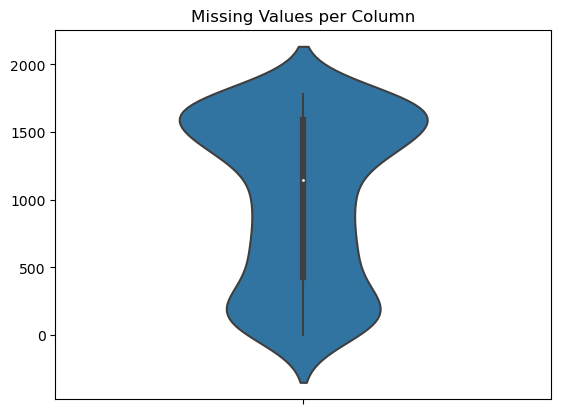

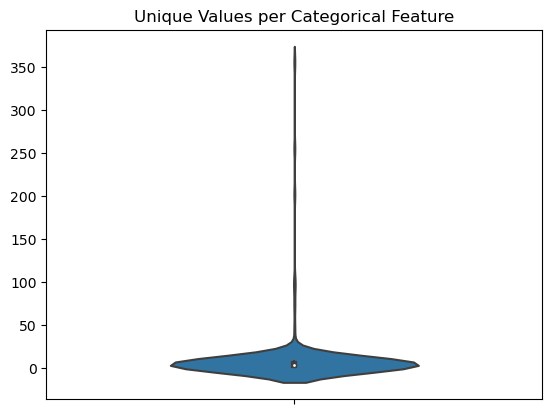

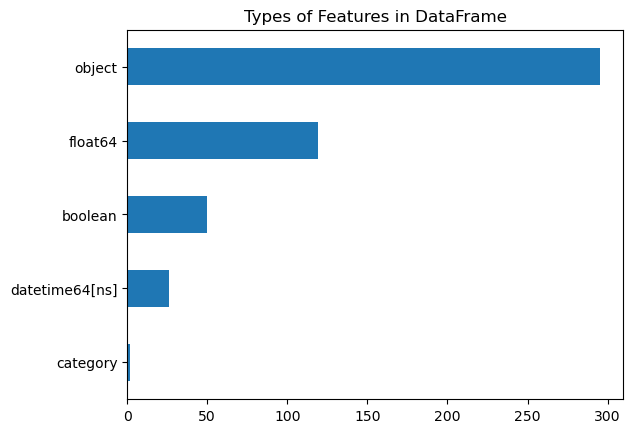

In [33]:
summarize_df(df)

### Summary

At this stage, the rough distributions of missing and unique vals remain similar, but there are overall more NaNs and less unique values. The increase in NaNs does not appear to be beneficial, however this is a result of binning and replacing a lot of NaN-equivalent values. These are values like 'data unavailable' or 'not applicable'. Modeling them as NaNs allows for easier inference of meaning from missing values and easier imputation (if applicable). There are still several incomplete steps in cleaning.

## Export clean data

In [47]:
col_list = df.columns.to_list()
colors = []
demo_end = col_list.index('Primary v. Recurrence') + 1
colors.extend(np.full(demo_end, 'BlueViolet'))
comorb_end = col_list.index('Diverting Ostomy Before Surgery') + 1
colors.extend(np.full(comorb_end - demo_end, 'Maroon'))
baseline_end = col_list.index('CA 19-9 (U/mL)') + 1
colors.extend(np.full(baseline_end - comorb_end, 'DarkGray'))
diag_end = col_list.index('Date of Biopsy') + 1
colors.extend(np.full(diag_end - baseline_end, 'MidnightBlue'))
pretreat_end = col_list.index('Liver First Approach') + 1
colors.extend(np.full(pretreat_end - diag_end, 'Brown'))
neoadj_end = col_list.index('Hospitalization Required') + 1
colors.extend(np.full(neoadj_end - pretreat_end, 'MediumTurquoise'))
posttreat_end = col_list.index('# Lung Lesions on Imaging') + 1
colors.extend(np.full(posttreat_end - neoadj_end, 'Salmon')) 
colors.append('Tan')  # Add color for 'Watch and Wait Protocol'
operative_end = col_list.index('EBL (mL)') # Addl. end cols added for 'Type of Intraop. Complication', use start feature of next segment
colors.extend(np.full(operative_end - (posttreat_end + 1), 'FireBrick'))
trans_end = col_list.index('Intraop UOP (ml)') + 1
colors.extend(np.full(trans_end - operative_end, 'DarkSeaGreen'))
histopath_end = col_list.index('Radial Margin Distance (mm)_Recurrence') + 1
colors.extend(np.full(histopath_end - trans_end, 'SteelBlue'))
postop_end = col_list.index('LOS Readmission') + 1
colors.extend(np.full(postop_end - histopath_end, 'Gold'))
adj_end = col_list.index('Reason for Delay in Adjuvant Treatment') + 1
colors.extend(np.full(adj_end - postop_end, 'DarkGray'))
followup_end = col_list.index('Surgery') + 1
colors.extend(np.full(followup_end - adj_end, 'DarkViolet'))
colors.append('Tan')  # Add color for 'COMMENTS'

# Sanity check here
assert len(colors) == len(col_list)
color_dict = dict(zip(col_list, colors))
with open('../Data Sources/Cleaned/color_dict.json', 'w') as fp:
    json.dump(color_dict, fp)

In [34]:
# NOTE: Using pickle allows dtypes to persist when re-loaded
df.to_pickle("../Data Sources/Cleaned/US_RCC_Database_CLEANED.pkl")

# UNUSED

## 4. Decouple compounded features
For example, a list of complications from a treatment. These should be split into multiple columns and one-hot encoded.
### Columns to be parsed (a * indicates that the column is a duplicate name and needs to be renamed): 
- Complication During Neoadjuvant Treatment (Side Note: This should be categorical, 'Yes' values should be removed and Imputated with median or similar)
- Type of Intraoperative Complication 
- Organs Invaded
- Neoadjuvant Chemo Regimen (Side Note: This feature needs to be adaquitely cleaned, some of the values are not consistent or straightforward)
- Adjuvant Chemo Regimen (Side Note: This feature needs to be adaquitely cleaned, some of the values are not consistent or straightforward)
- Chemotherapy Regimen-Recurrence (Side Note: This feature needs to be adaquitely cleaned, some of the values are not consistent or straightforward) *
### Processes
With many unique values, binning/n-grams will need to be practiced to handle misspellings or other mistakes. This will be done by splitting each value into tokens and compliling a list of unique values to inspect and bin. Many of these features also have secondary columns that indicate whether or not the specific features are present. For example, a Chemotherapy field with yes or no values that correspond to the entries in the Chemotherapy Regimen-Recurrence column. These will need to be removed to avoid confusing the model.

Diagnosis at readmission was discovered to need binning during dtype cleaning. Since binning is very time intensive with a dataset like this and the Nan count in the feature is 1358 after dtype cleaning pass 1, we will bin this iff it makes it past feature selection.

In [ ]:
count = df['Diagnosis at Readmission'].isna().sum()
print(count)

enumerator = 0
unique_tokens = []
for entry in therapy_complications:
    if null_values.get(enumerator) == False:
        if entry == 'No':
            new_values.append('No')
        elif entry == 'Yes':
            new_values.append("Yes")
        else:
            new_values.append('Yes')
        entry = entry.replace(';', ',')
        entry = entry.replace(', and', ',')
        tokens = entry.split(', ')
        trigger = False
        for token in tokens:
            token = token.lower()
            for u in unique_tokens:
                if token == u.lower():
                    trigger = True
            if (not trigger) and (token != 'no') and (token != 'yes') and (token != 'per notes'):
                unique_tokens.append(token)
            trigger = False
    else:
        new_values.append('No')
    enumerator += 1

## 5. Transform data
Some data in this dataset needs to be transformed to fit the same scale as other, related features.
### Columns to transform with units from/to in parenthesis (a * indicates that the column needs to be renamed): 
- Duration of Neoadjuvant Chemo-Days (Months/Days) *
- Duration of Neoadjuvant ChemoXRT-Days (Months/Days) *
- Adjuvant Chemo Duration-Days (Weeks/Days) *
- Adjuvant Chemoradiation Duration-Days (Weeks/Days) *

In [ ]:
#running this cell more than once WILL result in CORRUPTED VALUES, restart kernel before running

months_to_days = ['Duration of Neoadjuvant Chemo-Days', 'Duration of Neoadjuvant ChemoXRT-Days']
for feat in months_to_days:
    df[feat] = df[feat].infer_objects()
    df[feat] = df[feat].multiply(30)

weeks_to_days = ['Adjuvant Chemo Duration-Days', 'Adjuvant Chemoradiation Duration-Days']
for feat in weeks_to_days:
    df[feat] = df[feat].infer_objects()
    df[feat] = df[feat].multiply(7)

## 6. Drop single value columns
Just like it sounds, these are columns that only contain a single value. These will only serve to distract our model since it cannot draw an inference from a static value, so we need to drop them from our dataset.

In [ ]:
from feature_selector import FeatureSelector
fs = FeatureSelector(data = df)
fs.identify_single_unique()
print(fs.ops['single_unique'])
fs.plot_unique()

In [ ]:
fs.ops['single_unique']

In [ ]:
df = df.drop(columns=fs.ops['single_unique'])
df

## 8. Handling outliers
In numeric columns, outliers can signifigantly impare the function of a model. However, it can also be beneficial for the model to see that a value is higher than average. 
### Brainstorming
The first thing we need to do is filter out any non-numeric data, thanfully this will now be easy since we went through and cleaned out dtypes already. Ideally, I would like to create a folder containing data on each feature. I would like to use sklearn to find the 5-10 most related features and build graphs for each via seaborn's pairplot. Alternatively, we could simply create a large pairplot for each feature, acting as some form of a heat map.
#### Given that the methods to adjust outliers vary in end result given their application (regression or classification), it may be worth exploring implementing outlier adjustments in the dynamic learning process. Ideally, the method of fixing outliers will change based on whether the data is currently being used for regression or classification. This could also be an opprotunity to implement Minkowski error
### End Approach
Having read a few whitepapers that indicate the most effective methods of outlier detection and adjustment vary by whether or not the application is regression or classification. Since the proposed archetecture contains both, it would be un-ideal to implement just one for the ground truth dataset. Therefore we will focus more on the second proposal in the brainstorming section, implementing outlier correction on the fly during training. However, we will be creating two pairplots of features so anyone outside of this use case can visualize distributions and outliers of this cleaned version of the dataset for their own application.
#### Had to scrap pair grids, cell would not execute. Commented out code in case someone would like to borrow it
### Proposed pairplots
1. Box and Scatter plots 
2. Distribution and Bivariate kde plot

In [ ]:
import seaborn as sns; sns.set()
sns.set_palette("muted")
sns.set_color_codes()

In [ ]:
#box_scat = sns.PairGrid(df, dropna=True)
#box_scat = box_scat.map_diag(sns.boxplot, color = "o", orient = "v")
#box_scat = box_scat.map_offdiag(sns.scatter)
#box_scat.savefig("grid_boxandscat.png")

In [ ]:
#def hexabin(x, y):
#    plt.hexbin(x, y, gridsize=50, cmap="Blues")

In [ ]:
#distr_hex = sns.PairGrid(df, dropna=True)
#distr_hex = distr_hex.map_diag(sns.distplot, color = "o")
#distr_hex = distr_hex.map_offdiag(hexabin)
#istr_hex.savefig("grid_distrandhex.png")

## 9. Imputation
This dataset is incredibly dirty and has a lot of missing values, this means we have to impute, or fill in, these missing values. However the method of which we do this depends quite heavily on the specific feature and the data within, this means the dataset has to be gone over by hand. 
### Process:
The approach I will be taking here will be very similar to binning. The features will be split up into dictionaries to impute a defined default value, or a conditional value determined by a related feature. All remaining empty values will be filled by MICE, this is in lew of simply selecting the median or maximum occurred values from the column as such practices are less than ideal given they can be less accurate and even introduce bias into the data. MICE is done last since it works best with MAR data.
### Default values for categorical cols:
Typically a value such as 'None' would be imputed uniformly if a categorical column (with multiple categories, ie not simply yes and no) does not apply to a sample. However, this dataset uses many different NA values which means we need to locate these and replace them with a uniform alternative so these columns will be easier to work with when handling things like conditional logic.